# City Checkbook
This notebook demonstrates an exploration of City of Los Angeles purchase order data for supplies and services, as well as the creation of a machine learning predictor for whether the invoice was paid for in a timely manner.

## Background
As part of an "open data" initiatve, The City of Los Angeles makes available to the public its purchasing data, in the form of an "eCheckbook", available [here](https://controllerdata.lacity.org/Purchasing/eCheckbook-Data/pggv-e4fn).  Los Angeles City has 62,000 employees in dozens of departments, from the Police to the Harbor to the Zoo.  These purchases include office supplies, car parts for fleet vehicles, janitorial services for the offices, lawsuit settlements, equipment rentals and more.  Each record has up to 62 different attributes, although these are not all consistently filled out, or appropriate (e.g. a lawsuit settlement doesn't have a unit price.) The city does not supply any supporting documentation, and there are inconsistencies and nonsensical values in many entries.   The data used in this notebook had a preliminary filtering to attempt to isolate purchases of physical goods, but the city's category coding proved ambiguous, as discussed in more detail below.

In order to demonstrate the application of machine learning to purchase order data, these data were used to attempt to train a model which could predict when the city would make payments within 30 days of receiving a vendor invoice.  The available set of features included attributes like the city department (e.g Fire, Library, Mayor's office, etc.) making the purchase, the fund categories from which the money was drawn, in addition to basic info like the dollar amount and dates. It is certainly plausible that these and other factors might influence the responsiveness of the city to vendor invoices, so it makes sense to explore this with a machine learning approach.

## Preliminaries

In [ ]:
import boto3
import numpy as np                                # For matrix operations and numerical processing
import pandas as pd                               # For munging tabular data
import matplotlib.pyplot as plt                   # For charts and visualizations
import csv
import datetime
import os.path                                         # For manipulating filepath names
import uuid
import sagemaker                                  # Amazon SageMaker's Python SDK provides many helper functions
from sagemaker import get_execution_role

Create a unique tag for labeling folders to keep results separate if the notebook is run again.  Make sure to only run this cell once.

In [ ]:
uniq_tag=str(uuid.uuid4())
print(uniq_tag)

Get the SageMaker session here to use the default bucket.  Eventually the data will be moved somewhere generally accessible rather than my private account.

In [ ]:
sess = sagemaker.Session()

In [ ]:
bucket=sess.default_bucket()
prefix='sagemaker-citycheckbook-{}'.format(uniq_tag)
rawkey='sagemaker-citycheckbook/e_checkbook/LACity_eCheckbook_Data.csv'
rawfile=os.path.basename(rawkey)

In [ ]:
s3_client = boto3.client('s3')

Download the "raw" data.  This file has actually been lightly filtered relative to the raw download from the city's webpage.  These data have had the following filters applied:
* `EXPENDITURE TYPE` must be one of (`55010 PARTS & MATERIALS`, `SUPPLIES & OTHER SERVICES`, `COMMODITIES PURCHASES`).  These appear to be the categories for physical items, but the "OTHER SERVICES" appears to be liberally interpreted by city employees.
* `PAYMENT STATUS` must be `PAID`
* `FISCAL YEAR` must be one of (`2016`, `2017`, `2018`).  This was just to keep the volume manageable.
* `SETTLEMENT/JUDGEMENT` must be blank.  These appear to be court-related payouts.

In [ ]:
s3_client.download_file(bucket, rawkey, rawfile)

## Exploratory Data Analysis

Load the data into a pandas dataframe for exploration.  The notebook instance must have enough memory to do this.

In [ ]:
raw=pd.read_csv(rawfile, dialect='excel')

In [ ]:
raw.info()

In [ ]:
raw.head()

Let's examine which departments are the most represented, since we almost certainly want the department as one of our predictor variables.

In [ ]:
raw['DEPARTMENT NAME'].value_counts()

How much money are we talking about?

In [ ]:
raw['DOLLAR AMOUNT'].describe()

Appears there are some big ticket items on there.  Let's check what those are, out of curiousity.

In [ ]:
raw[['DEPARTMENT NAME','DETAILED ITEM DESCRIPTION','DOLLAR AMOUNT', 'QUANTITY','UNIT PRICE']].loc[raw['DOLLAR AMOUNT']>3e6]

The \\$14 million for a helicopter makes sense, and is the actual purchase of a physical item.  However, the City Clerk lumping together all the costs for a city election into one \\$3 million entry isn't really the granularity we were hoping for, nor is the LAPD grouping \\$4.4 million in spending on body camera and taser guns, which presumably involved some physical items.

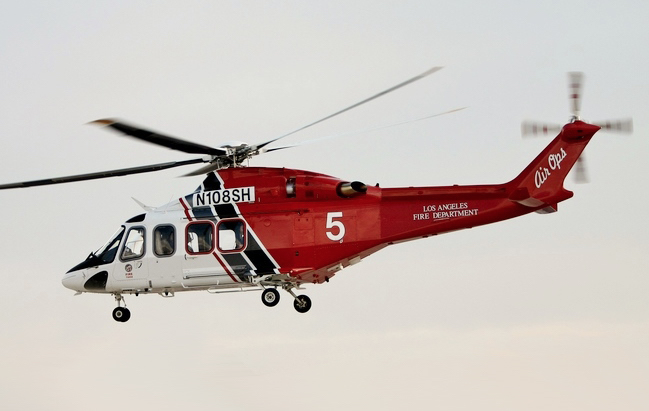
Tax Dollars At Work ([Wikipedia](https://commons.wikimedia.org/wiki/File:LAFD_fire_5_(cropped).jpg))

In [ ]:
raw[['DEPARTMENT NAME','EXPENDITURE TYPE','DETAILED ITEM DESCRIPTION','DOLLAR AMOUNT']].loc[(raw['DEPARTMENT NAME']=='CULTURAL AFFAIRS') & (raw['EXPENDITURE TYPE']=='COMMODITIES PURCHASES')]

In [ ]:
raw['FUND TYPE'].value_counts()

Rules on funds are likely different in who/when/how they can be drawn down.  We'll include this as a feature for the model.

In [ ]:
raw['EXPENDITURE TYPE'].loc[raw['FISCAL YEAR']==2016].value_counts()

In [ ]:
raw['EXPENDITURE TYPE'].loc[raw['FISCAL YEAR']==2017].value_counts()

In [ ]:
raw['EXPENDITURE TYPE'].loc[raw['FISCAL YEAR']==2018].value_counts()

It looks like the city had some change in policy about how to code purchases of goods and services.  That could affect our model, because entries from 2016 may not really be the same kinds of things are 2018.  Additional research would be needed to explore this.

In [ ]:
print((raw['UNIT PRICE'].loc[raw['UNIT PRICE']>0]).count())
print((raw['QUANTITY'].loc[raw['QUANTITY']>0]).count())

Many things seem to have quantities and unit prices, so we'll include those as well.  It's plausible that there's a difference between one big ticket item (e.g., a helicopter) and a large order of many inexpensive things at once.  Additionally, entries without quantities are less likely to be tangible goods.

Let's look at what the high-quantity items are:

In [ ]:
raw[['DETAILED ITEM DESCRIPTION', 'DEPARTMENT NAME','QUANTITY','UNIT PRICE', 'DOLLAR AMOUNT']].loc[raw['QUANTITY']>10000]

Looks like fuel purchases, among others.  Unknown how the city buys that, and a more complete analysis might separate these purchases from physical goods like office supplies.

## Data Cleaning

Let's clean up some of the obvious issues, like negative dollar amounts and transactions (payments) which occur before the invoice.  There may be significance to these, but without documentation from the city, we don't know.  It could just be data-entry/accounting errors.

Make a mapping dictionary from column name to index

In [ ]:
C = {}
for i,colname in enumerate(raw.columns):
    C[colname]=i

In [ ]:
print(C)

Create a function to parse date strings into datetime objects

In [ ]:
def parse_date(d):
    mm,dd,yyyy = tuple(map(int, d.split('/')))
    return datetime.date(yyyy,mm,dd)

This is a cleaning function which will eliminate entries where the dollar amount, quantity or unit price are zero or negative.  This reads through the old CSV file and writes a new CSV file.  In many notebooks, cleaning is done by wrangling the pandas dataframe that we have in memory above.  My personal preference is to write code in more function forms, because it will translate better to EMR or other ETL processing which may be necessary if the data become very large.  Using pandas for data transformations is great until it isn't.  If scale is on the horizon, always write transformations which are streaming or parallelizable. 

In [ ]:
def clean_data(infile, outfile, header=1):
    #-- create output handler
    fhout = open(outfile, 'w')
    writer = csv.writer(fhout, dialect='excel')
    
    with open(infile, 'r') as fhin:
        reader = csv.reader(fhin, dialect='excel')
        for cols in reader:
            if(header>0):
                writer.writerow(cols)
                header -= 1
                continue

            skip = False

            #-- make sure the dollar amount is non-negative (unclear what those entries mean), 
            #-- and that the quantity and unit price values have been entered
            #-- Also ensure that the entry can be made into a floating point value

            for key in ('DOLLAR AMOUNT','QUANTITY','UNIT PRICE'):
                if(not skip):
                    try:
                        value = float(cols[C[key]])
                        if(value<=0):
                            skip=True
                    except ValueError:
                        skip = True
            
            
            #-- make sure the date order is: purchase order, invoice, transaction (payment)
            #-- entries where this order isn't present are discarded
            if(not skip):
                transaction_date = parse_date(cols[C['TRANSACTION DATE']])
                inv_date = parse_date(cols[C['INV DATE']])
                po_date = parse_date(cols[C['PO DATE']])
                po_to_invoice = inv_date - po_date
                invoice_to_trans = transaction_date - inv_date
                
                if( int(invoice_to_trans.days)<0 or
                    int(po_to_invoice.days)<0 ):
                    skip = True
                    
            if(skip):
                continue
            else:
                writer.writerow(cols)
    fhout.close()

Execute the cleaning; a new file will be generated in the notebook.

In [ ]:
cleanfile = "cleaned_{}".format(rawfile)
clean_data(rawfile, cleanfile, header=1)

## Data Transform

Function to produce a one-hot-encoded representation of a categorical variable.  Another thing for which there are pandas utilities, if the data fit in memory.  Roll your own and have complete control.

In [ ]:
def one_hot(x, mapping):
    return [int(x==m) for m in mapping]

Create a function to transform the cleaned (but otherwise unaltered) data into a format which can be used by the model.  In particular, we need to create a target variable: "was the time between invoice and payment less than 30 days?", and we need to convert the many categorical variables into one-hot encoded column sets.  The numeric variables like dollar amount we will pass through unchanged.

This is a repeat of the functional form of program described above.  While pandas can do a number of these wrangling steps when the data are in memory, it cannot work at scale.  Moreover, this particular functionality (translating the raw data to model-ready data) will *have* to be coded elsewhere as an ETL or Lambda operation in an automated production scenario, as the notebook is only for interactive operations.

In [ ]:
def transform_data(infile, outfile, header=1):
    fields = ("DOLLAR AMOUNT",
              "QUANTITY",
              "UNIT PRICE",
              "PAYMENT METHOD",
              "EXPENDITURE TYPE",
              "BU NAME",
              "DEPARTMENT NAME",
              "FUND TYPE",
              "DATA SOURCE", 
              "CALENDAR MONTH")

    categorical = ("PAYMENT METHOD",
                   "EXPENDITURE TYPE",
                   "BU NAME",
                   "DEPARTMENT NAME",
                   "FUND TYPE",
                   "DATA SOURCE",
                   "CALENDAR MONTH")

    entries = {}
    for field in categorical:
        entries[field] = set()
    
    target = []
    iheader = header
    with open(infile, 'r') as fh:
        reader = csv.reader(fh, dialect='excel')
        for cols in reader:
            if(iheader>0):    
                iheader -= 1
                continue

            #-- days between events
            transaction_date = parse_date(cols[C['TRANSACTION DATE']])
            inv_date = parse_date(cols[C['INV DATE']])
            po_date = parse_date(cols[C['PO DATE']])
            po_to_invoice = inv_date - po_date
            invoice_to_trans = transaction_date - inv_date
            
            #-- create the target variable (the thing to be estimated)
            target.append( int(invoice_to_trans.days<30) )
            
            #-- collect unique entries for categorical variables
            for field in categorical:
                entries[field].add(cols[C[field]])

    #-- unpack the category mappings
    mappings = {}
    for field in categorical:
        mappings[field] = sorted(list(entries[field]))

    #-- encoded columns starts with target variable
    encoding = ['target']
    
    for field in fields:
        if(field in categorical):
            colname = [field+" "+m for m in mappings[field]]
        else:
            colname = [field]
        encoding.extend(colname)
    
    print("\n".join(encoding))
    
    #-- save the encoded column order
    with open('encoding.txt', 'w') as fh:
        for field in encoding:
            fh.write(field+"\n")
    
    fhout = open(outfile, 'w')
    writer = csv.writer(fhout, dialect='excel')

    i = 0
    iheader = header
    with open(infile, 'r') as fh:
        reader = csv.reader(fh, dialect='excel')
        for cols in reader:
            if(iheader>0):    
                iheader -= 1
                continue

            outcols = [ target[i] ]
            i+=1

            skip = False
            for field in fields:
                if(field in categorical):
                    outc = one_hot(cols[C[field]], mappings[field])
                else:
                    try:
                        outc = [float(cols[C[field]])]
                    except ValueError:
                        print(field, cols[C[field]])
                        skip = True
                outcols.extend(outc)
                
            if(not skip):
                writer.writerow(outcols)
    fhout.close()

Perform the encoding, yielding model-ready data and a text file with the column names.

In [ ]:
encodedfile = "encoded_{}".format(rawfile)
transform_data(cleanfile, encodedfile, header=1)

The model does not accept column headers, so they were saved to a text file during the transformation as a convenience.  Read those for later.

In [ ]:
column_names = pd.read_csv('encoding.txt', header=None)
column_names = list(column_names[0].values)

Load the encoded data into pandas for examination

In [ ]:
encoded = pd.read_csv(encodedfile, names=column_names, header=None)

Examine the target variable distribution.  If this was very lopsided, we might evaluate if we're estimating the right variable, or if we've got enough data to support estimating on the small category.

In [ ]:
encoded['target'].value_counts()

Function to split rows of a CSV file randomly into train/validate/test CSV files.  Another case of rolling a memory-safe version of a pandas convenience function.

In [ ]:
def split3(infile, breaks, header=0):

    filenames = ('train.csv', 'validate.csv', 'test.csv')
    filehandles = {}
    for filename in filenames:
        filehandles[filename] = open(filename, 'w')

    assert(len(breaks)==2), "Must provide to breakpoints between 0 and 1"
    assert(breaks[0]<breaks[1]), "Breaks must be in order"
    
    with open(infile, 'r') as fhin:
        reader = csv.reader(fhin, dialect='excel')
        for cols in reader:
            if(header>0):    
                header -= 1
                continue
            r = np.random.random()

            if(r<=breaks[0]):
                fh = filehandles[filenames[0]]
            elif(r<=breaks[1]):
                fh = filehandles[filenames[1]]
            elif(r<=1):
                fh = filehandles[filenames[2]]
            else:
                raise RuntimeError("Should never get here")
            result=",".join(cols)
            fh.write(result+"\n")

    for filename in filenames:
        filehandles[filename].close()
    print("Created train/validate/test files")
    return filenames

Perform 70%/20%/10% train/validate/test split.

In [ ]:
trainfile, validatefile, testfile = split3(encodedfile, [0.7,0.9])

AWS Models need the data available in S3.  The XGBoost model we're using will need both a train and validate set to iterate its learning

In [ ]:
s3_client.upload_file(validatefile, bucket, "{}/train/{}".format(prefix, trainfile))
s3_client.upload_file(validatefile, bucket, "{}/validate/{}".format(prefix, validatefile))

Check the test split, see if the distribution of target outcomes is about what we saw in the train split.  If it wasn't, something was wrong with our randomization (or we were very unlucky.)

In [ ]:
test_data = pd.read_csv(testfile, names=column_names, header=None)
test_data['target'].value_counts()

## Model Training

We're going to use the AWS SageMaker built-in implementation of XGBoost ("Extreme Gradient Boosted Trees").  This is a popular and effective ensemble method for machine learning.  It creates many different models which each try to split the feature data at some effective point for discriminating outcomes, then uses the combined results of all those individual models to get a consensus about a particular outcome given input data.  The open source version of the algorithm is detailed [here](https://xgboost.readthedocs.io/en/latest/), the AWS SageMaker optimized implementation is detailed [here](https://docs.aws.amazon.com/sagemaker/latest/dg/xgboost.html).

In [ ]:
from sagemaker.amazon.amazon_estimator import get_image_uri
container = get_image_uri(boto3.Session().region_name, 'xgboost')

Define input, the instance types to train on, and hyperparmeters

In [ ]:
s3_input_train = sagemaker.s3_input(s3_data='s3://{}/{}/train/'.format(bucket, prefix), content_type='csv')
s3_input_validation = sagemaker.s3_input(s3_data='s3://{}/{}/validate/'.format(bucket, prefix), content_type='csv')

In [ ]:
role = get_execution_role()

xgb = sagemaker.estimator.Estimator(container,
                                    role, 
                                    train_instance_count=1, 
                                    train_instance_type='ml.m4.xlarge',
                                    output_path='s3://{}/{}/output'.format(bucket, prefix),
                                    sagemaker_session=sess)
xgb.set_hyperparameters(max_depth=5,
                        eta=0.2,
                        gamma=4,
                        min_child_weight=6,
                        subsample=0.8,
                        silent=0,
                        objective='binary:logistic',
                        num_round=100)

Execute the training.  This can take several minutes.

In [ ]:
xgb.fit({'train': s3_input_train, 'validation': s3_input_validation})

# Examining the Model

Because AWS SageMaker performs its training on non-notebook nodes, the model artifacts are stored in S3.  In order to unpack the details of the model, we have to make a copy of the model artifacts on the notebook and load the object.  Fortunately, XGBoost is also implemented in open source python module, so we can use hooks from that module to examine the model.  Note this sub section is purely diagnostic curiousity, and not strictly part of a train/deploy operation

The following conda installs are necessary to examine the trained model.  They only need to be done once per notebook environment and can take several minutes, so they're wrapped in try/except blocks.

In [ ]:
try:
    import xgboost
except ImportError:
    !conda install -y -c conda-forge xgboost

try:
    import graphviz
except ImportError:
    #!conda install -y -c conda-forge graphviz
    !conda install -y -c conda-forge python-graphviz

import xgboost
import graphviz

In [ ]:
from xgboost import plot_tree
from xgboost import to_graphviz
import urllib
import pickle

In [ ]:
u = urllib.parse.urlsplit(xgb.model_data)

In [ ]:
s3_client.download_file(u.netloc, u.path[1:], 'model.tar.gz')

In [ ]:
!tar -xzvf model.tar.gz

In [ ]:
booster = pickle.load(open('xgboost-model', 'rb'))

Because we trained the model without column name information, it just knows them as feature `f1`...`fN`.  Make a mapping to the encoded columns so we can interpret things.

In [ ]:
feature_map={}
for c,f in list(zip(column_names[1:], booster.feature_names)):
    feature_map[f]=c

Let's see what the model considered the most important features when deciding if a payment was going to be within 30 days.

In [ ]:
for f,g in sorted(booster.get_score(importance_type='gain').items(), key=lambda kv:kv[1], reverse=True):
    print("{:0.2f}\t{}".format(g, feature_map[f]))

In [ ]:
gvtext = to_graphviz(booster, num_trees=1, rankdir='UT')
gvtext

Since we've loaded the model locally, we can make predictions in the notebook.  This is sort of off-label, but it's convenient for development and research.  First lets make a copy of the "truth" as came from the original data (test split.)

In [ ]:
ytrue = test_data['target'].copy()

Drop the target variable from the test data (inference is made on the \[1:\] columns), and run it through the model to get predictions.

In [ ]:
test_d = xgboost.DMatrix(test_data.drop('target', axis=1).as_matrix())

ypred = booster.predict(test_d)

In [ ]:
len(ypred[np.where(1-ytrue)])

In [ ]:
len(ypred)

In [ ]:
idx = np.where(ytrue)
plt.plot(np.arange(len(idx[0])), np.sort(ypred[idx]), 'b.')
plt.plot(np.arange(len(idx[0])), np.ones(len(idx[0]))*0.5, 'k:')

In [ ]:
idx = np.where(1-ytrue)
plt.plot(np.arange(len(idx[0])), np.sort(ypred[idx]), 'r.')
plt.plot(np.arange(len(idx[0])), np.ones(len(idx[0]))*0.5, 'k:')

Make the confusion matrix:

In [ ]:
cm=pd.crosstab(index=ytrue, columns=np.round(ypred), rownames=['actuals'], colnames=['predictions'])
cm

In [ ]:
acc = (cm[1][1]+cm[0][0]) / len(ytrue)
acc

In [ ]:
pre = (cm[1][1]) / (cm[1][1]+cm[1][0])
pre

# Deploying an Endpoint

For real-time inference, one can very easily deploy an endpoint which can give low latency model predictions by ingesting data sent to the endpoint.  SageMaker handles all the provisioning necessary for the requested node.  Note however that real-time inference endpoints accumulate cost by the hour.  For applications which don't require real time inference, "batch transform" can be configured in which costs are only accumualted for the resources consumed. 

In [ ]:
xgb_predictor = xgb.deploy(initial_instance_count=1,
                           instance_type='ml.m4.xlarge')

In [ ]:
from io import StringIO

Function to split the input data into chunks of 500 rows each and send them to the real-time endpoint

In [ ]:
def predict(data, rows=500):
    split_array = np.array_split(data, int(data.shape[0] / float(rows) + 1))
    predictions = ''
    for array in split_array:
        #body = ",".join(["{}".format(x) for x in array])
        #print(body)
        s = StringIO()
        np.savetxt(s, array,delimiter=',')
        body = s.getvalue()
        predictions = ','.join([predictions, xgb_predictor.predict(body.encode('utf-8')).decode('utf-8')])
    return np.fromstring(predictions[1:], sep=',')

In [ ]:
td = test_data.drop(test_data.columns[0],axis=1).as_matrix()

Execute prediction by endpoint on test set

In [ ]:
predictions = predict(td)

Examine the confusion matrix

In [ ]:
cm = pd.crosstab(index=test_data['target'], columns=np.round(predictions), rownames=['actuals'], colnames=['predictions'])
cm

In [ ]:
acc = (cm[1][1]+cm[0][0]) / len(ytrue)
acc

In [ ]:
pre = (cm[1][1]) / (cm[1][1]+cm[1][0])
pre

# Clean up

Very important to terminate the real-time inference endpoint if it is not in use.  Costs can accumulate quickly because these are robust instance types.

In [ ]:
sagemaker.Session().delete_endpoint(xgb_predictor.endpoint)